# Explainable Convolutional Neural Networks

   <font size="3" face="微软雅黑">SHAP (SHapely Additive exPlanations) 使深度学习中Black-box models成为过去，通过使用SHAP来解释deep learning models的预测，只需要几行代码。下面，将以MNIST数据集为例，展示SHAP方法的应用。</font><br />
 <font size="3" face="微软雅黑">CNN可能很难理解。一个网络从图像中学习最优特征提取器（核），这些特征对于检测任何有助于网络正确分类图像的模式都是有用的。</font><br />
<font size="3" face="微软雅黑">你的大脑也没什么不同。它还使用一系列模式来识别你面前的物体。例如，什么使数字0为0 ?它是一个圆形到椭圆形的轮廓，里面什么都没有。这是卷积层背后的内核试图学习的一般模式。</font><br />
 <font size="3" face="微软雅黑">如果您想要直观地表示您的模型解释，只需看看SHAP(形状相加解释)，这是一种解释任何机器学习模型输出的博弈论方法。</font><br />
 ## PyTorch Deep Explainer MNIST example
 <font size="3" face="微软雅黑">一个简单的例子展示了如何解释MNIST CNN训练使用PyTorch与Deep Explainer。</font><br />

## 定义模型结构
 <font size="3" face="微软雅黑">您将使用PyTorch训练一个简单的手写数字分类器。这是一个用于研究和商业领域的深度学习的Python库。如果您以前没有使用过PyTorch，但有一些Python经验，那么它会让您感觉很自然。<br />
    
在定义模型架构之前，您必须导入几个库。其中大多数与PyTorch有关，**numpy**和**shap**将在后面使用:<br />
    
 **torch** 和**torchvision** 是 pytorch** 基本的的库。torch 自然指的是 pytorch， torchvision 是独立于 pytorch 的关于图像操作的一些方便工具库。torchvision主要包括以下几个包：<br />
    
 (1)**vision.datasets** : 几个常用视觉数据集，可以下载和加载，这里主要的高级用法就是可以看源码如何自己写自己的Dataset的子类。<br />
    
(2)**vision.models**: 流行的模型，例如 AlexNet, VGG, ResNet 和 Densenet 以及 与训练好的参数。<br />
   
(3)**vision.transforms** : 常用的图像操作，例如：随机切割，旋转，数据类型转换，图像到tensor ,numpy 数组到tensor , tensor 到 图像等。<br />
    
(4)**vision.utils** : 用于把形似 (3 x H x W) 的张量保存到硬盘中，给一个mini-batch的图像可以产生一个图像格网。  </font><br />

  

In [23]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap

 <font size="3" face="微软雅黑">模型体系结构很简单，并且借鉴了[官方文档](https://github.com/slundberg/shap/blob/master/notebook)。您可以随意声明自己的架构，但这个架构已经足够满足我们的需求了。<br />
    
**下面的部分将向您展示如何训练模型。**</font><br />
## 训练模型
 <font size="3" face="微软雅黑">让我们从声明几个变量开始:<br />
    
**batch_size**：一次显示给模型的图像数量 <br />
        
**num_epoch**：通过全部训练数据集的完整次数 <br />
    
**iterations（迭代）**：每一次迭代都是一次权重更新，每一次权重更新需要batch_size个数据进行Forward运算得到损失函数，再BP算法更新参数。1个iteration等于使用batchsize个样本训练一次。 <br />
    
**momentum**：SGD 算法里面的 momentum（动量)<br />  
**log-interval：**多少个 batch 打印一次训练状态，batch=10,batch_size=64,即每640张图片打印一次训练结果<br />
    
**seed：**随机种子<br /> 
    
**save-model：**是否保存模型<br />
    
**epochs：**被定义为向前和向后传播中所有批次的单次训练迭代。这意味着1个epoch是整个输入数据的单次向前和向后传递。简单说，epochs指的就是训练过程中数据将被“轮”多少次。 亦即应当完整遍历数据集多少次（一次为一个epoch）。<br />
    
**device** —指定是在CPU或GPU上完成的训练。如果你没有兼容cuda的GPU，用cpu替换cuda:0<br />
    
接下来，您将声明两个函数——train()和test()。这些将被用来在单独的子集上训练和评估模型，并打印中间结果。 <br />
    
 CPU擅长统领全局等复杂操作，GPU擅长对大数据进行简单重复操作。CPU是从事复杂脑力劳动的教援，而GPU是进行大量并行计算的体力劳动者。深度学习是模拟人脑神经系统而建立的数学网络模型，这个模型的最大特点是，需要大数据来训练。
 </font><br />

In [66]:
batch_size = 128
num_epochs = 2
#将数据转移的cpu
device = torch.device('cpu')
#模型
class Net(nn.Module):
#构建只看init部分就可以了
    
    def __init__(self):#构造函数
        
        super(Net, self).__init__() # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        self.conv_layers = nn.Sequential(
              nn.Conv2d(1, 10, kernel_size=5),#卷积层
              nn.MaxPool2d(2),#池化
              nn.ReLU(),#采用relu激活函数
              nn.Conv2d(10, 20, kernel_size=5),  
              nn.Dropout(), #减少过拟合，训练集中使用
              nn.MaxPool2d(2),
              nn.ReLU())
             
            
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)#nn.Softmax（）分类，就是概率，该样本属于各个类的概率 dim = 0指第一个维度，dim = 1指第二个维度，dim = 2指第三个维度，
         )
#将数据送到模型，模型如何处理的过程
    def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)#在torch里面，view函数相当于numpy的reshape，x.view(-1, 320)这里-1表示一个不确定的数，就是你如果不确定你想要reshape成几行，但是你很肯定要reshape成320列，那不确定的地方就可以写成-1
            x = self.fc_layers(x)
            return x
#  model指建立好的网络模型；device指模型在哪个设备上运行，CPU还是GPU；train_loader是指数据集；optimizer用于优化；epoch指整个数据集训练的次数   
        
def train(model, device, train_loader, optimizer, epoch):
    #模型进入训练模式，对应的有model.eval()只有前传
    model.train()
    #加载训练数据集合，这里一次 128 张图片以及对应的类别（0 - 9），data 是图片 shape 为[128, 1, 28, 28]，128张图片，灰度图片，像素大小为28*28。 target 是 128个图片的类别，每个用 0-9 的图片表示。
    for batch_idx,(data, target) in enumerate(train_loader):# batch_idx为索引，（data, targe）
        data,target=data.to(device), target.to(device)# data为图像，target为label
        #将梯度初始化为零
        optimizer.zero_grad()
        #前向传播求出预测的值
        output = model(data)
        #计算当前损失
        loss = F.nll_loss(output.log(), target)
        # 反向传播，用来计算梯度
        loss.backward()
        #更新所有参数
        optimizer.step()
        if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
    
            
def test(model, device, test_loader):
    model.eval()# 只有前传，没有反向求梯度调参
    test_loss = 0
    correct = 0
    with torch.no_grad():# 代表with下面的代码块，不参与反向传播，不更新参数
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
#Operator: x /= y，Meaning:  x  = x / y

    test_loss /= len(test_loader.dataset)#损失的平均值
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

 <font size="3" face="微软雅黑">接下来，你可以使用torchvision下载数据集。数据模块。然后，数据集被加载和转换(转换为张量和归一化)，并分批组织。 </font><br />

In [67]:
#加载训练集和测试集，pytorch 自带有 MNIST 数据集。 并且转为我们需要的格式
#train_loader 里面就是 6000 个训练集，包含有图片和图片的标签
train_loader = torch.utils.data.DataLoader(#数据加载器，结合了数据集合取样器，并且可以提供多个线程处理数据集。在训练模型时使用到此函数，用来把训练数据分成多个小组，此函数每次抛出一组数据。直至把所有的数据都抛出。就是做一个数据的初始化
    datasets.MNIST('mnist_data',#表示MNIST加载到本目录下
                   train=True,#表示是否加载数据库的训练集，false的时候加载测试集
                   download=True,#表示是否自动下载MNIST数据集
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]#表示是否需要对数据进行预处理)),
                   batch_size=batch_size, 
                   shuffle=True#每迭代一次所有元素重新排
                   )
        
#test_loader 里面就是 1000 个训练集，包含有图片和图片的标签
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

 <font size="3" face="微软雅黑">现在您已经为模型训练做好了一切准备。下面是如何实例化模型，并根据之前声明的epoch数目训练它:</font><br />

In [68]:
#构建模型，并送到CPU中加速
model = Net().to(device)
#优化方法是SGD，第一个参数是模型的参数，第二个参数是学习率，第三个参数是动量
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317254
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.121725
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.099225
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.795205
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.773730

Test set: Average loss: 0.0045, Accuracy: 9017/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.777544
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.423909
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.533545
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.475752
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.440797

Test set: Average loss: 0.0025, Accuracy: 9347/10000 (93%)



<font size="3" face="微软雅黑">请记住——实际值在您的机器上可能略有不同，但您应该在测试集上达到95%以上的精度。<br />
    
**Next step – interpretations with SHAP!**</font><br />
## 解释模型
<font size="3" face="微软雅黑">预测解释现在就像编写几行代码一样简单。下面的代码片段从测试集中加载一批随机图像，并解释其中五个图像的预测:<br />


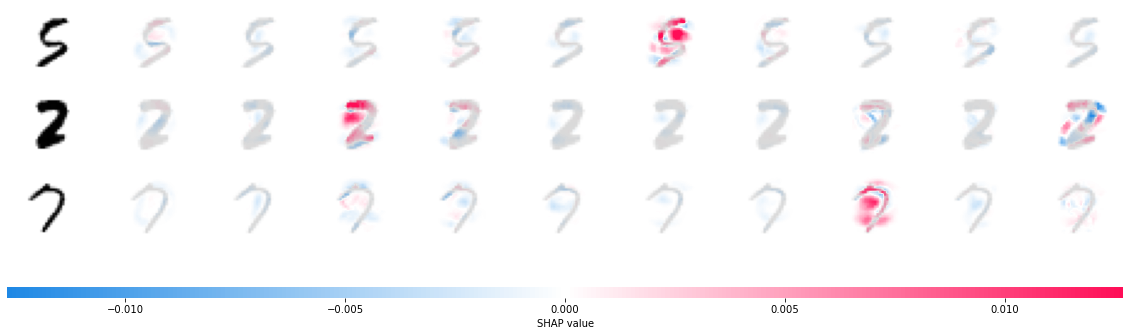

In [96]:
# since shuffle=True, this is a random sample of test data
#iter()函数获取这些可迭代对象的迭代器。然后我们可以对获取到的迭代器不断使⽤next()函数来获取下⼀条数据。
batch = next(iter(test_loader))
# print(batch[0])
# print(batch[1])
images, _ = batch

background = images[:100]
test_images = images[100:103]
#print(test_images)
# shap.DeepExplainer是用于解释深度学习模型的
#shap.KernelExplainer可用于解释所有的模型，尽管它运行时间比其他解释器时间长一点，但是它能够给出一个近似的的Shap values.
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
# print(shap_values)
#numpy.swapaxes(arr, axis1, axis2)arr：输入的数组; axis1：对应第一个轴的整数 ;axis2：对应第二个轴的整数 ;将数组arr所对应的axis1轴和axis2轴交换位置 即可
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
# print(shap_numpy)
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
 # plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)




<font size="3" face="微软雅黑">输入图像显示在左边，每个类的解释显示在右边。任何用红色表示的东西都会增加模型输出(模型对分类更有信心)，而用蓝色表示的东西会减少输出。
这就是形状解释在卷积神经网络中的作用。</font><br />
